In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

hfb = h5py.File('../../clustering/lhc-olympics-preprocessing/images64_8_rsn066/bkg_imgs.h5', 'r')
hfs = h5py.File('../../clustering/lhc-olympics-preprocessing/images64_8_rsn066/sig_imgs.h5', 'r')
sig = hfs['multijet']
bkg = hfb['multijet']

n_sig = sig.shape[0]

sig_hlf = pd.read_hdf('../../clustering/lhc-olympics-preprocessing/merged/sigHLF_merged.h5', stop=n_sig)
bkg_hlf = pd.read_hdf('../../clustering/lhc-olympics-preprocessing/merged/bkgHLF_merged.h5', stop=n_sig)


mjj = np.concatenate([sig_hlf['mjj'], bkg_hlf['mjj']])
x = np.concatenate([sig, bkg[:n_sig]])
y = np.concatenate([np.ones(n_sig), np.zeros(n_sig)])

X_train, X_test, y_train, y_test, mjj_train, mjj_test \
    = train_test_split(x, y, mjj, test_size=0.33, random_state=1)

X_train, X_valid, y_train, y_valid, mjj_train, mjj_valid  \
    = train_test_split(x, y, mjj, test_size=0.2, random_state=1)

In [2]:
from tensorflow.keras.regularizers import L1, L2, L1L2

batch_size = 32
img_height = 64
img_width = 64

l1 = 1e-6 
l2 = 1e-6

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)


model = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, 1)),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

epochs=25
history = model.fit(
  x=X_train, y=y_train,
  validation_data=(X_valid, y_valid),
  epochs=epochs,
  batch_size=batch_size,
  callbacks=[reduce_lr]
)




Epoch 1/25
5000/5000 [==============================] - 43s 4ms/step - loss: 0.4257 - accuracy: 0.8031 - val_loss: 0.3124 - val_accuracy: 0.8751
Epoch 2/25
5000/5000 [==============================] - 17s 3ms/step - loss: 0.3060 - accuracy: 0.8783 - val_loss: 0.2677 - val_accuracy: 0.8935
Epoch 3/25
5000/5000 [==============================] - 18s 4ms/step - loss: 0.2751 - accuracy: 0.8908 - val_loss: 0.2802 - val_accuracy: 0.8899
Epoch 4/25
5000/5000 [==============================] - 17s 3ms/step - loss: 0.2550 - accuracy: 0.9001 - val_loss: 0.2432 - val_accuracy: 0.9061
Epoch 5/25
5000/5000 [==============================] - 18s 4ms/step - loss: 0.2445 - accuracy: 0.9045 - val_loss: 0.2518 - val_accuracy: 0.9011
Epoch 6/25
5000/5000 [==============================] - 18s 4ms/step - loss: 0.2354 - accuracy: 0.9083 - val_loss: 0.2209 - val_accuracy: 0.9145
Epoch 7/25
5000/5000 [==============================] - 18s 4ms/step - loss: 0.2274 - accuracy: 0.9124 - val_loss: 0.2176 - val_ac

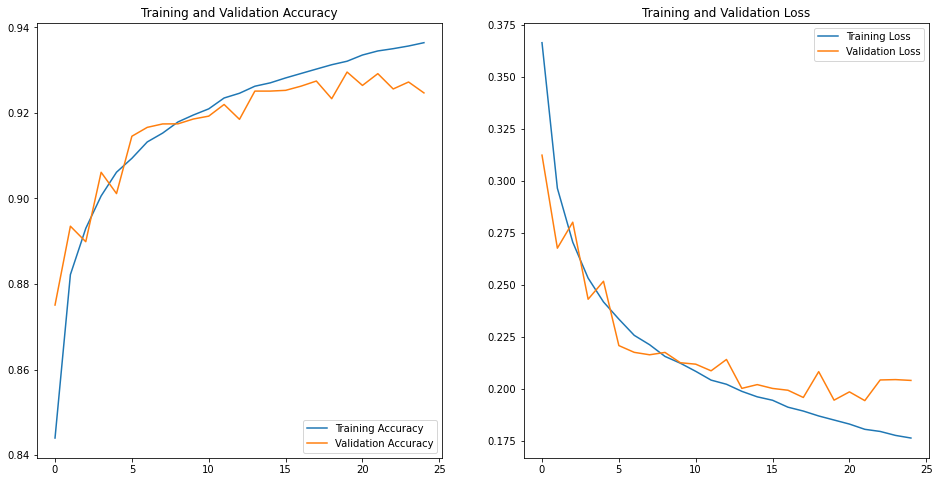

In [3]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#plt.savefig("training.svg")
plt.close()

0.5774000883102417


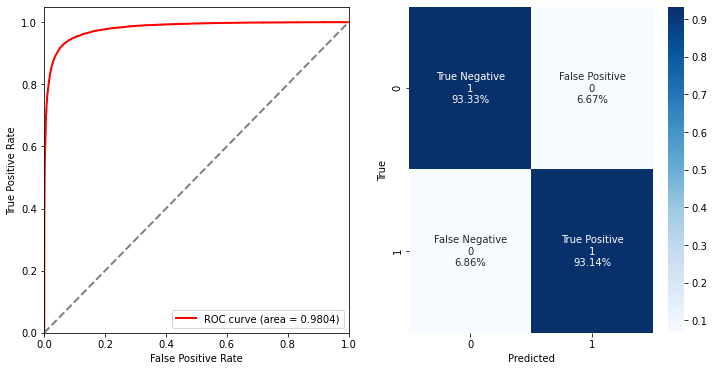

In [4]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

y_score = model.predict(X_test)

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

prc = np.percentile(y_score, 50)
print(prc)
cf_matrix = confusion_matrix(y_test, (y_score>=prc).astype(int), normalize='true')
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
plt.subplot(1, 2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.ylabel("True")
plt.xlabel("Predicted")
#plt.savefig("performance.svg")
plt.show()

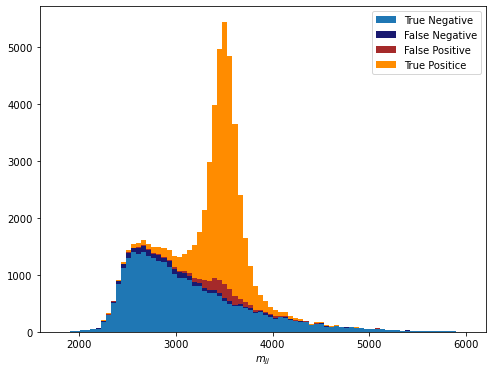

In [5]:
sig_pred = (y_score>=prc).astype(int).ravel() == 1
sig_true = y_test == 1

plt.figure(figsize=(8,6))
plt.tight_layout()
plt.hist([mjj_test[~sig_pred&~sig_true], mjj_test[sig_pred&~sig_true], 
          mjj_test[~sig_pred&sig_true], mjj_test[sig_pred&sig_true]], 
          80, stacked=True, range=(1800,6000),
          color=['C0', 'midnightblue', 'brown', 'darkorange'],
          label=['True Negative', 'False Negative', 'False Positive','True Positice'])
plt.title("")
plt.xlabel(r"$m_{jj}$")
plt.legend()
plt.savefig("mjj.svg")
plt.show()